# Preliminaries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
from kneed import KneeLocator

from tqdm import tqdm

# Data Preprocessing

In [10]:
df = pd.read_csv('C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_01SUAL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dropping of columns

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207770 entries, 0 to 207769
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   RUN_TIME            207770 non-null  object 
 1   MKT_TYPE            207770 non-null  object 
 2   REGION_NAME         207770 non-null  object 
 3   ZONE_NAME           207770 non-null  object 
 4   RESOURCE_NAME       207770 non-null  object 
 5   TIME_INTERVAL       207770 non-null  object 
 6   START_TIME          207770 non-null  object 
 7   END_TIME            207770 non-null  object 
 8   MP_NAME             203198 non-null  object 
 9   PRICE1              207770 non-null  float64
 10  QUANTITY1           207770 non-null  float64
 11  PRICE2              207770 non-null  float64
 12  QUANTITY2           207770 non-null  float64
 13  PRICE3              156538 non-null  float64
 14  QUANTITY3           156538 non-null  float64
 15  PRICE4              135981 non-nul

In [12]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [13]:
# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]
result_df

,RUN_TIME,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
0,06/26/2021,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,...,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,...,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,...,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,...,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,...,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207765,09/25/2023 11:35:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207766,09/25/2023 11:40:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207767,09/25/2023 11:45:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
207768,09/25/2023 11:50:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN


In [14]:
df[selected_columns].describe()

,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,PRICE10,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
count,207770.000000,207770.000000,156538.000000,135981.000000,106064.000000,68023.000000,46507.000000,27378.000000,19064.000000,12075.000000,...,207770.00000,156538.000000,135981.000000,106064.000000,68023.000000,46507.000000,27378.000000,19064.000000,12075.0,0.0
mean,-9982.411698,-9982.411698,6330.662704,6638.287493,9468.679347,8218.169812,8247.459099,7673.769812,7499.398246,6939.055824,...,435.95919,470.953061,507.717313,556.298593,566.308396,582.260090,588.849733,620.411404,647.0,NaN
std,778.696008,778.696008,4255.536670,2968.681447,4484.238521,2530.938379,2880.159307,2422.090631,3361.997321,1544.920035,...,143.29933,119.245691,102.325418,84.896164,71.156089,60.025191,40.347317,21.374078,0.0,NaN
min,-10000.000000,-10000.000000,-9999.000000,1500.080000,2470.080000,2480.080000,2490.080000,3000.080000,3655.080000,3656.080000,...,180.00000,226.000000,300.000000,350.000000,352.000000,500.000000,550.000000,600.000000,647.0,NaN
25%,-10000.000000,-10000.000000,2862.200000,4646.810000,6000.080000,6065.080000,5600.080000,5570.080000,5600.080000,5770.080000,...,290.00000,350.000000,450.000000,500.000000,500.000000,500.000000,550.000000,600.000000,647.0,NaN
50%,-10000.000000,-10000.000000,5201.080000,6100.080000,8893.080000,8793.080000,8600.080000,6900.080000,6550.080000,6560.080000,...,450.00000,456.000000,500.000000,550.000000,600.000000,600.000000,580.000000,620.000000,647.0,NaN
75%,-10000.000000,-10000.000000,8700.080000,8900.080000,10040.080000,9600.080000,9800.000000,9650.080000,9100.080000,7500.080000,...,541.00000,566.900000,600.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.0,NaN
max,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,28000.080000,29000.080000,16504.080000,...,647.00000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.0,NaN


In [15]:
#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

## FFill NaNs with last Price-Quantity Bid

In [16]:
# Forward fill from the first non-null value in each row for the price columns
result_df.loc[:, 'price1':'price11'] = result_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
result_df.loc[:, 'quantity1':'quantity11'] = result_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

## TAKES 30 SECONDS TO RUN
result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,06/26/2021,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,...,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
1,06/26/2021 12:05:00 AM,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,...,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
2,06/26/2021 12:10:00 AM,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,...,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
3,06/26/2021 12:15:00 AM,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,...,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
4,06/26/2021 12:20:00 AM,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,...,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207765,09/25/2023 11:35:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,647.0
207766,09/25/2023 11:40:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,647.0
207767,09/25/2023 11:45:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,647.0
207768,09/25/2023 11:50:00 PM,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,...,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,647.0


## Filter to 2022 data

In [17]:
result_df['run_time'] = result_df['run_time'].astype(str)

C:\Users\Francia\AppData\Local\Temp\ipykernel_13484\2012798107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['run_time'].astype(str)


In [18]:
df_2022 = result_df[result_df['run_time'].str[6:10]=='2022']
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
37575,01/01/2022,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,250.0,276.2,356.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
37576,01/01/2022 12:05:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,250.0,276.2,356.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
37577,01/01/2022 12:10:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,250.0,276.2,356.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
37578,01/01/2022 12:15:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,250.0,276.2,356.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
37579,01/01/2022 12:20:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,250.0,276.2,356.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0


In [19]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,...,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000
mean,-9983.792128,-9983.792128,1215.796471,1719.234674,2347.137740,2381.181109,2387.032794,2388.046075,2388.094313,2388.094313,...,490.696247,538.437543,582.307322,613.518362,624.192163,627.920456,629.044539,629.138121,629.138121,629.138121
std,824.911442,824.911442,8769.925254,9022.607863,9607.103604,9649.704908,9653.128678,9653.804338,9653.838251,9653.838251,...,135.830753,114.579809,97.924711,79.982481,75.146033,73.469997,73.080573,73.041389,73.041389,73.041389
min,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
25%,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,350.000000,450.000000,550.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
50%,-10000.000000,-10000.000000,4582.690000,4998.970000,5000.080000,5000.080000,5000.080000,5000.080000,5000.080000,5000.080000,...,541.000000,563.200000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
75%,-10000.000000,-10000.000000,7550.080000,8150.080000,8890.080000,8900.080000,8900.080000,8900.080000,8900.080000,8900.080000,...,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
max,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000


## Normalize quantity values

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = df_2022[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(df_2022[quantity_columns].shape)

# Update the DataFrame with the scaled values
df_2022.loc[:, quantity_columns] = scaled_quantities

In [21]:
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
37575,01/01/2022,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37576,01/01/2022 12:05:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37577,01/01/2022 12:10:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37578,01/01/2022 12:15:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37579,01/01/2022 12:20:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,...,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000,62192.000000
mean,-9983.792128,-9983.792128,1215.796471,1719.234674,2347.137740,2381.181109,2387.032794,2388.046075,2388.094313,2388.094313,...,0.758418,0.832206,0.900011,0.948251,0.964748,0.970511,0.972248,0.972393,0.972393,0.972393
std,824.911442,824.911442,8769.925254,9022.607863,9607.103604,9649.704908,9653.128678,9653.804338,9653.838251,9653.838251,...,0.209939,0.177094,0.151352,0.123621,0.116145,0.113555,0.112953,0.112892,0.112892,0.112892
min,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759,0.347759
25%,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,0.540958,0.695518,0.850077,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,-10000.000000,-10000.000000,4582.690000,4998.970000,5000.080000,5000.080000,5000.080000,5000.080000,5000.080000,5000.080000,...,0.836167,0.870479,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,-10000.000000,-10000.000000,7550.080000,8150.080000,8890.080000,8900.080000,8900.080000,8900.080000,8900.080000,8900.080000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Obtain bidding curve and price series for clustering

In [23]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022#.iloc[:10000]

# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for regular quantity intervals
    step_fx = interp1d(quantities, prices, kind='next', fill_value='extrapolate')
    step = df_2022['quantity11'].max() / 10

    # Create a finer quantity range for interpolation
    intp_quantities = np.arange(df_2022['quantity1'].min(), df_2022['quantity11'].max() + 0.1, step)
    
    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)
    
    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000
    
    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|█████████████████████████████████████████████████████████| 62192/62192 [00:59<00:00, 1045.76it/s]


In [24]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

array([[-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       ...,
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08]])

In [79]:
# Export price series to a new graph - remember to change the powerplant name

# Specify the CSV file path
csv_file_path = 'C:/Users/Francia/Desktop/data/consolidated_csv_01SUAL_G01_price_series.csv'

# Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

Array has been saved to C:/Users/Francia/Desktop/data/consolidated_csv_01SUAL_G01_price_series.csv


Processing: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [08:15<00:00, 20.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


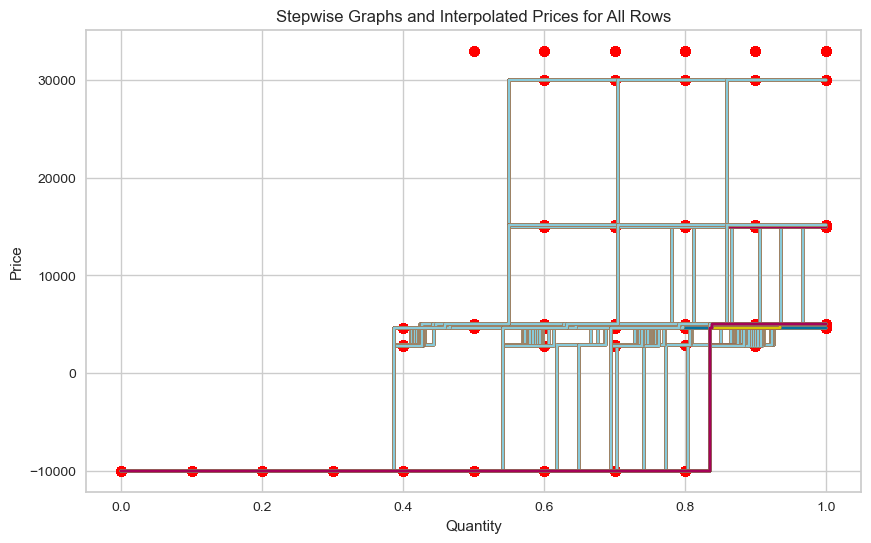

In [82]:
# Plot all stepwise curves on a single graph
plt.figure(figsize=(10, 6))

for quantities, prices, intp_quantities, intp_prices in tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing'):
    plt.step(quantities, prices, where='pre')
    plt.scatter(intp_quantities, intp_prices, color='red')

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Stepwise Graphs and Interpolated Prices for All Rows')
plt.legend()
plt.show()

# K-Means Clustering

In [25]:
# Create a DataFrame with the original data and cluster labels
price_series_df = pd.DataFrame(price_series, columns=[f'Feature_{i+1}' for i in range(price_series.shape[1])])

In [26]:
price_series_df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11
0,-10000.0,-10000.0,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08
1,-10000.0,-10000.0,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08
2,-10000.0,-10000.0,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08
3,-10000.0,-10000.0,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08
4,-10000.0,-10000.0,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08


## Identify best number of clusters

In [34]:
wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,16)

for k in tqdm(K, desc='Clustering Progress'):
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(price_series_df)
    kmeans_model.fit(price_series_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(price_series_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(price_series_df, kmeans_model.labels_)

Clustering Progress: 100%|█████████████████████████████████████████████████████████████| 14/14 [19:34<00:00, 83.89s/it]


### Visual Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

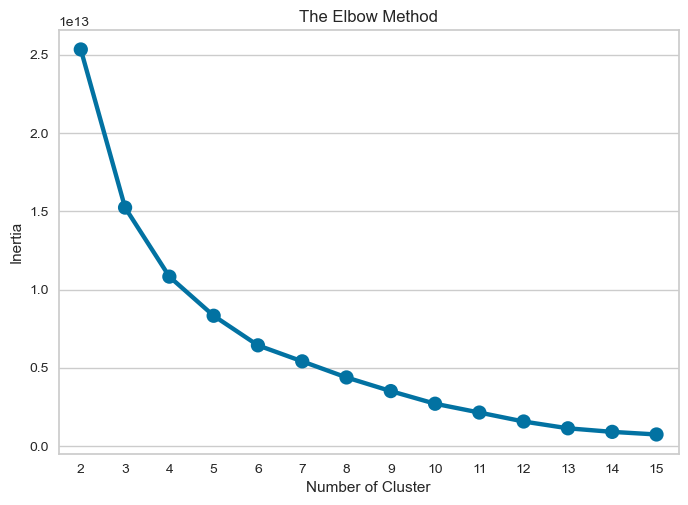

<Figure size 800x550 with 0 Axes>

In [35]:
# Check results of elbow method

plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [37]:
# Locate the knee or elbow
cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 5 clusters


### Mathematical Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

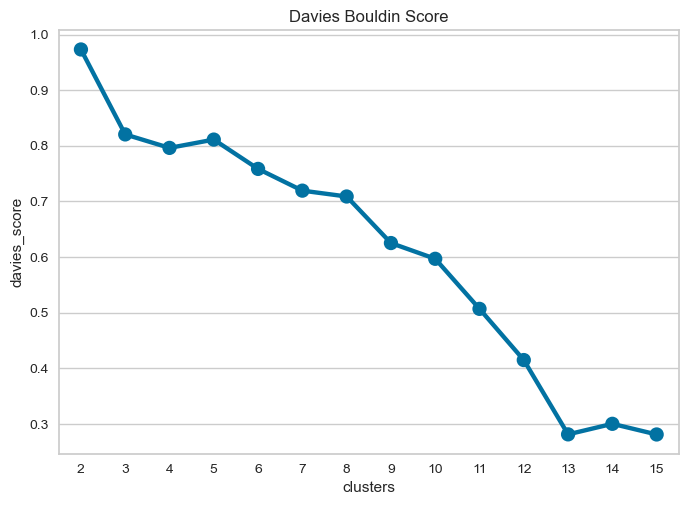

<Figure size 800x550 with 0 Axes>

In [40]:
# Create plot for Davies-Bouldin score

plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

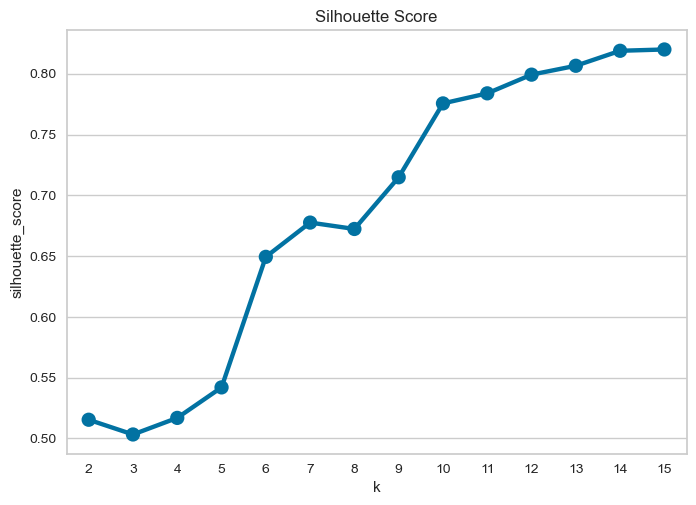

<Figure size 800x550 with 0 Axes>

In [41]:
# Create plot for silhouette score

plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [43]:
# Create function for silhouette plot

def silhouette_plot(X , n_list):
    silhouette_scores = []
    for k in tqdm(n_list, desc='Progress'):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k, random_state=42, n_init=10)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

Progress:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]

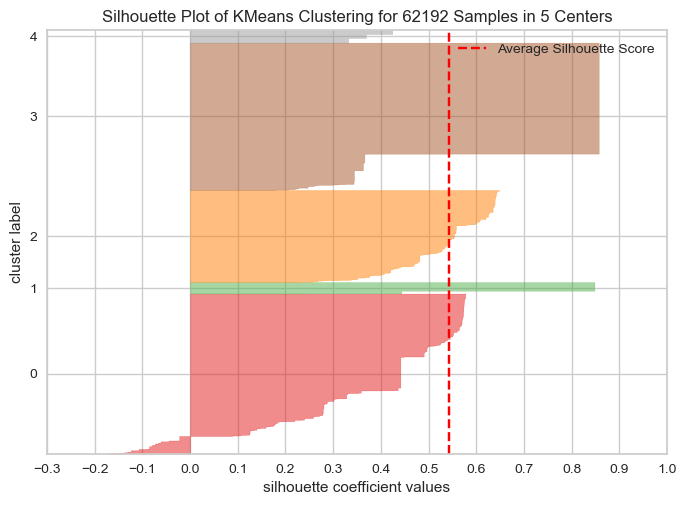

Progress:  20%|██████████████▌                                                          | 1/5 [02:48<11:12, 168.16s/it]

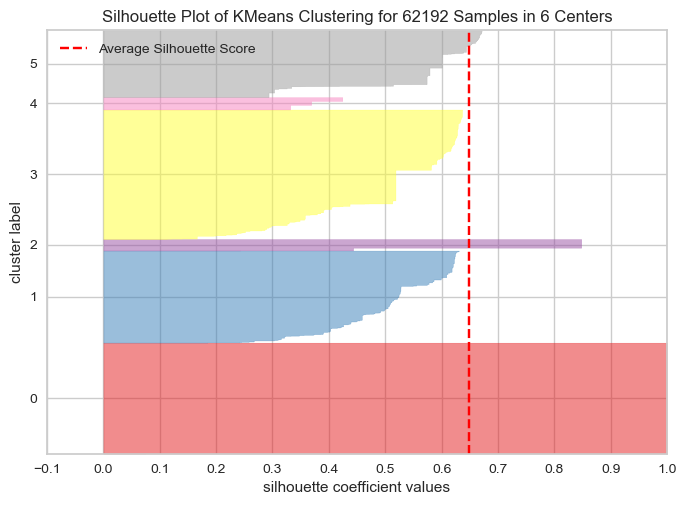

Progress:  40%|█████████████████████████████▏                                           | 2/5 [05:29<08:11, 163.88s/it]

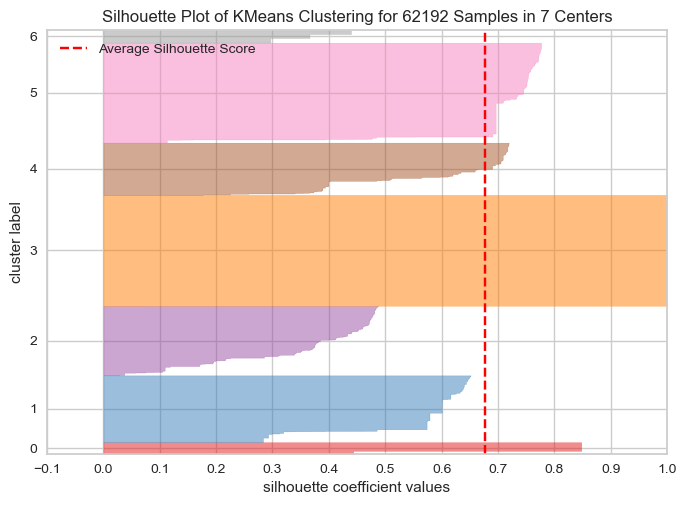

Progress:  60%|███████████████████████████████████████████▊                             | 3/5 [08:16<05:30, 165.35s/it]

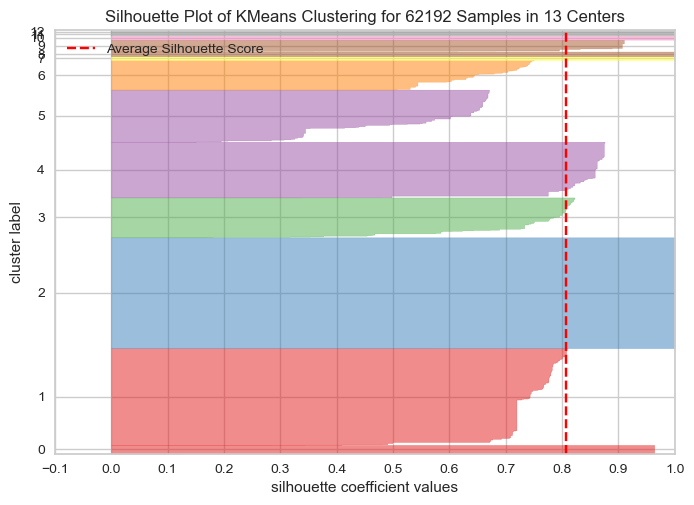

Progress:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [10:59<02:44, 164.37s/it]

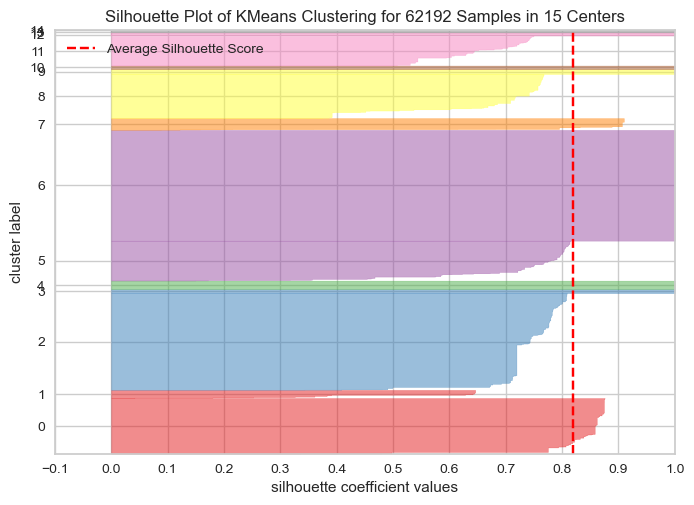

Progress: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [13:46<00:00, 165.27s/it]


[[0.5420213755042598, 5],
 [0.649387476606903, 6],
 [0.6775647374384589, 7],
 [0.8065299612470853, 13],
 [0.8199370108989417, 15]]

In [44]:
# Create silhouette plot

k_cluster_test = [5, 6, 7, 13, 15]

silhouette_plot(price_series_df , k_cluster_test)

## Clustering with chosen k

In [173]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 4

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_

# Now, cluster_labels contains the assigned cluster for each row
# You can use these labels for further analysis or visualization


C:\Users\Francia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
price_series

array([[-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       [-10000.  , -10000.  , -10000.  , ...,  15000.08,  15000.08,
         15000.08],
       ...,
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08],
       [-10000.  , -10000.  , -10000.  , ...,   9280.08,   9300.08,
          9300.08]])

### Modified Clustering

In [32]:
from scipy.stats import wasserstein_distance
from scipy.cluster.vq import kmeans, vq

# Specify the number of clusters
k = 3

# Define a custom distance metric (Wasserstein distance)
def wasserstein_distance_metric(u, v):
    return wasserstein_distance(u, v)

# Perform k-means clustering
centroids, _ = kmeans(price_series_df.iloc[:3000], k, iter=20, thresh=1e-05, metric=wasserstein_distance_metric)

# Assign each data point to the nearest cluster
labels, _ = vq(data, centroids)

# Print centroids and labels
print("Cluster Centers:\n", centroids)
print("Labels:\n", labels)

TypeError: kmeans() got an unexpected keyword argument 'metric'

In [ ]:
#from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform clustering
def kmeans_clustering(data, k):
    kmeans = KMeans(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmeans.fit(data)
    return kmeans.labels_, kmeans.cluster_centers_

# Function to calculate Separation Threshold
def separation_threshold_ratio(labels, centers, theta_0, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = theta_0 * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > RHO_0:
            return True

    return False

# Function to process a chunk
def process_chunk(K):
    labels, centers = kmedoids_clustering(subset_step_curves_array, K)
    return separation_threshold_ratio(labels, centers, THETA_0, P_ref), centers

### Snake plot

C:\Users\Francia\AppData\Local\Temp\ipykernel_15456\3315188144.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.t

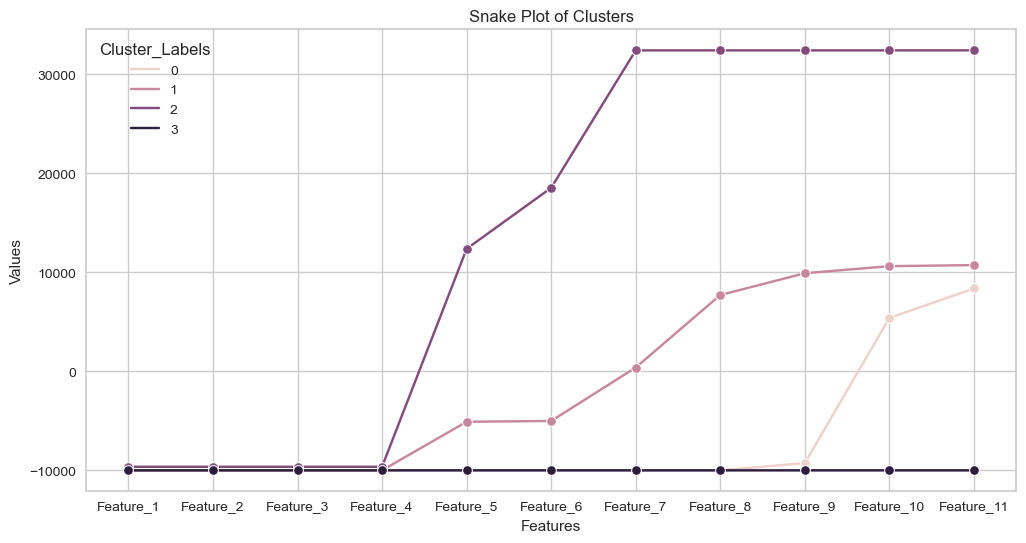

In [139]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### TSNE graph

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

<Axes: title={'center': 'Flattened Graph of 6 Clusters'}>

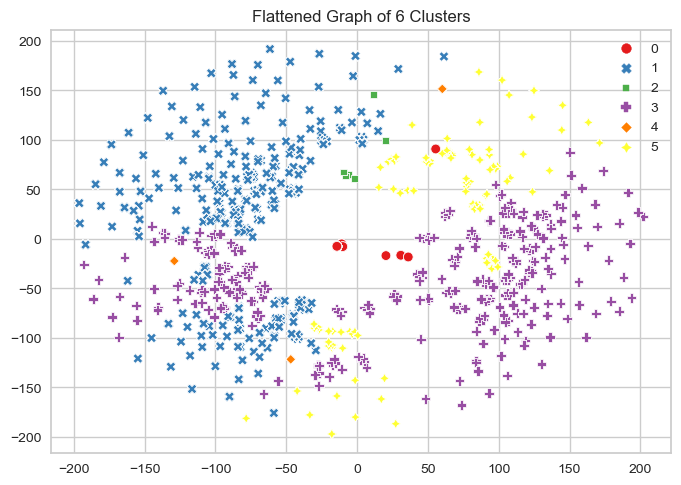

In [70]:
# Initialise TSNE
model = TSNE(random_state=1)
transformed = model.fit_transform(price_series_df)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

### Count plot

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

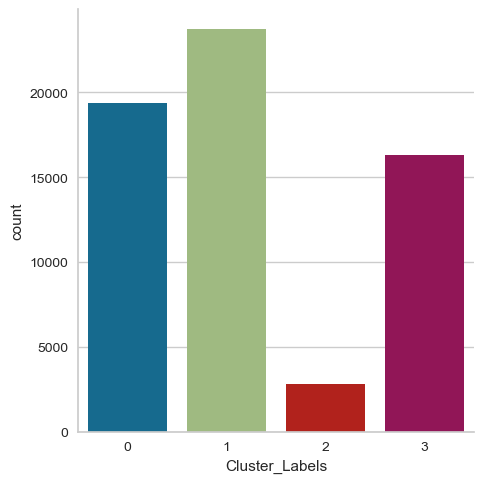

In [89]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count"
  )
plt.show()

## Stepwise Clustering

In [90]:
price_series_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Cluster_Labels
0,-10000.0,-10000.0,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,1
1,-10000.0,-10000.0,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,1
2,-10000.0,-10000.0,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,1
3,-10000.0,-10000.0,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,1
4,-10000.0,-10000.0,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
62187,-10000.0,-10000.0,-10000.0,-10000.0,9200.08,9200.08,9260.08,9280.08,9280.08,9300.08,9300.08,1
62188,-10000.0,-10000.0,-10000.0,-10000.0,9200.08,9200.08,9260.08,9280.08,9280.08,9300.08,9300.08,1
62189,-10000.0,-10000.0,-10000.0,-10000.0,9200.08,9200.08,9260.08,9280.08,9280.08,9300.08,9300.08,1
62190,-10000.0,-10000.0,-10000.0,-10000.0,9200.08,9200.08,9260.08,9280.08,9280.08,9300.08,9300.08,1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.91s/it]


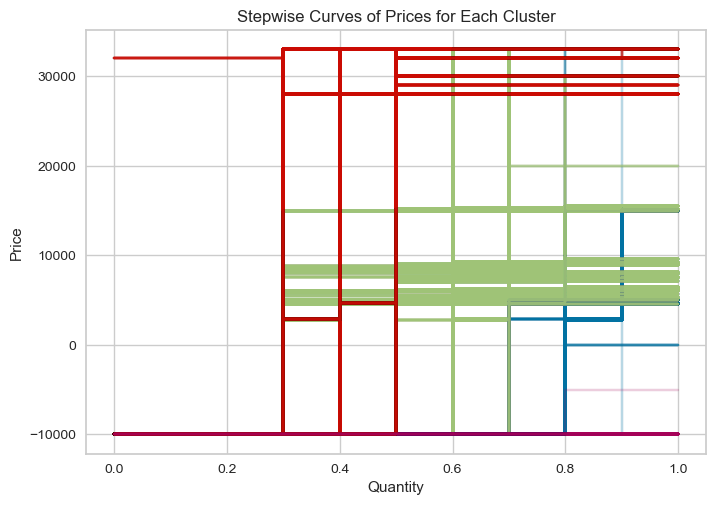

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming clustered_df is your DataFrame with 12 columns (11 price columns + cluster labels)
# and the cluster labels column is named 'cluster'

# Define the quantity step
quantity_step = 0.1

# Define the range of quantities from 0 to 1 with the specified step
quantities = np.arange(0, 1.1, quantity_step)

# Extract the price columns
price_columns = [f'Feature_{i}' for i in range(1, 12)]

# Group by cluster labels
grouped_clusters = price_series_df.groupby('Cluster_Labels')

# Plot stepwise curves for each cluster
for cluster, group in tqdm(grouped_clusters):
    # Select the first 10000 curves or all if less than 10000
    group = group.head(10000) if len(group) >= 10000 else group
    
    # Plot stepwise curves
    for index, row in group.iterrows():
        prices = row[price_columns]
        plt.step(quantities, prices, where='pre', color=f'C{cluster}', alpha=0.1, label=f'Cluster {cluster}')

# Customize the plot
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Stepwise Curves of Prices for Each Cluster')
plt.show()


## Time Distribution Attempt

In [174]:
time_distribution = df_2022.copy()

In [175]:
time_distribution.reset_index(drop=True, inplace=True)
time_distribution.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/01/2022,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,01/01/2022 12:05:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,01/01/2022 12:10:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,01/01/2022 12:15:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,01/01/2022 12:20:00 AM,-10000.0,-10000.0,2854.0,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,...,0.386399,0.426893,0.550232,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [176]:
time_distribution = time_distribution[['run_time', 'price1']]
time_distribution.head()

,run_time,price1
0,01/01/2022,-10000.0
1,01/01/2022 12:05:00 AM,-10000.0
2,01/01/2022 12:10:00 AM,-10000.0
3,01/01/2022 12:15:00 AM,-10000.0
4,01/01/2022 12:20:00 AM,-10000.0


In [177]:
# Assuming df is your DataFrame
split_values = time_distribution['run_time'].str.split(' ', n=1, expand=True)
time_distribution['date'] = split_values[0]
time_distribution['time'] = split_values[1].fillna('12:00:00 AM')
time_distribution.head()

,run_time,price1,date,time
0,01/01/2022,-10000.0,01/01/2022,12:00:00 AM
1,01/01/2022 12:05:00 AM,-10000.0,01/01/2022,12:05:00 AM
2,01/01/2022 12:10:00 AM,-10000.0,01/01/2022,12:10:00 AM
3,01/01/2022 12:15:00 AM,-10000.0,01/01/2022,12:15:00 AM
4,01/01/2022 12:20:00 AM,-10000.0,01/01/2022,12:20:00 AM


In [178]:
time_distribution = time_distribution.drop(columns = ['run_time', 'price1'])
time_distribution.head()

,date,time
0,01/01/2022,12:00:00 AM
1,01/01/2022,12:05:00 AM
2,01/01/2022,12:10:00 AM
3,01/01/2022,12:15:00 AM
4,01/01/2022,12:20:00 AM


In [179]:
time_distribution['cluster_labels'] = cluster_labels
time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,12:00:00 AM,1
1,01/01/2022,12:05:00 AM,1
2,01/01/2022,12:10:00 AM,1
3,01/01/2022,12:15:00 AM,1
4,01/01/2022,12:20:00 AM,1


In [153]:
time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,12:00:00 AM,1
1,01/01/2022,12:05:00 AM,1
2,01/01/2022,12:10:00 AM,1
3,01/01/2022,12:15:00 AM,1
4,01/01/2022,12:20:00 AM,1


In [180]:
#time_distribution['date'] = pd.to_datetime(time_distribution['date'])
time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')
time_distribution['time'] = time_distribution['time'].dt.time

time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,00:00:00,1
1,01/01/2022,00:05:00,1
2,01/01/2022,00:10:00,1
3,01/01/2022,00:15:00,1
4,01/01/2022,00:20:00,1


In [181]:
time_distribution['time'] = time_distribution['time'].astype(str)
time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,00:00:00,1
1,01/01/2022,00:05:00,1
2,01/01/2022,00:10:00,1
3,01/01/2022,00:15:00,1
4,01/01/2022,00:20:00,1


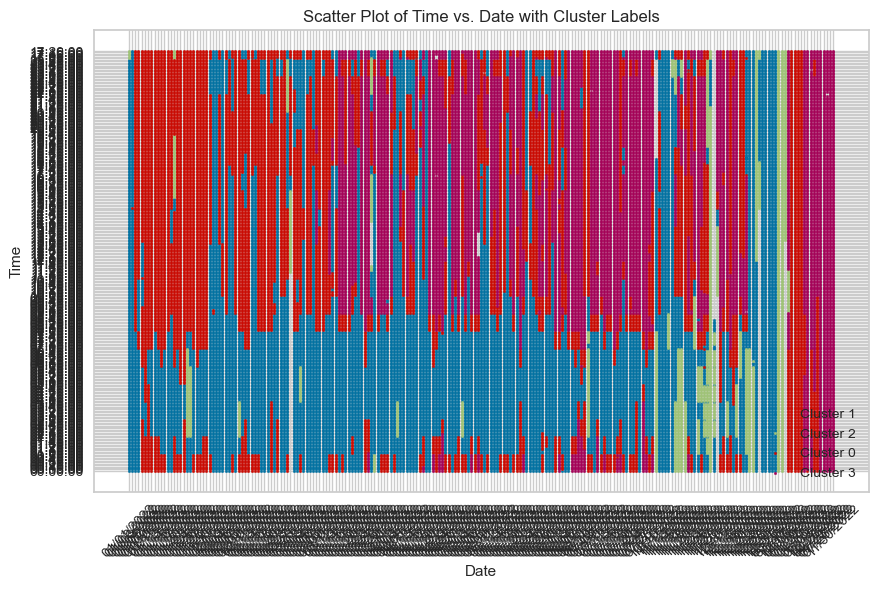

In [183]:
#time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')

# Plot scatter plot
plt.figure(figsize=(10, 6))

# Use scatter plot with different colors for each cluster label
for cluster_labels in time_distribution['cluster_labels'].unique():
    cluster_data = time_distribution[time_distribution['cluster_labels'] == cluster_labels]
    plt.scatter(cluster_data['date'], cluster_data['time'], label=f'Cluster {cluster_labels}', s=3)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Time')
plt.title('Scatter Plot of Time vs. Date with Cluster Labels')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

In [165]:
time_distribution['date'].value_counts()

date
2022-12-20    310
2022-01-01    288
2022-06-03    288
2022-05-24    288
2022-05-25    288
             ... 
2022-11-28    168
2022-02-27    152
2022-10-30    130
2022-12-26    108
2022-11-27    104
Name: count, Length: 219, dtype: int64

TypeError: float() argument must be a string or a real number, not 'datetime.time'

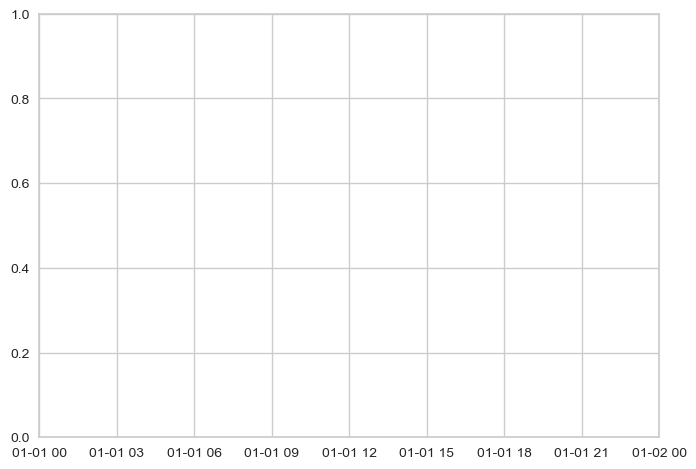

In [156]:
plt.scatter(time_distribution['date'], time_distribution['time'], c=time_distribution['cluster_labels'], cmap='viridis', s=1)  # Adjust 's' for smaller points
plt.xlabel('Date')
plt.ylabel('Time')
plt.title('Scatter Plot with Cluster Labels')
plt.legends()
plt.show()

In [145]:
time_distribution['time'].value_counts()

time
10:50:00 PM    217
11:35:00 PM    217
10:05:00 PM    217
10:15:00 PM    217
10:20:00 PM    217
              ... 
8:50:00 AM      39
8:45:00 AM      39
8:40:00 AM      39
9:00:00 AM      39
9:05:00 AM      38
Name: count, Length: 504, dtype: int64

In [151]:
test_time_distribution = pd.DataFrame()

test_time_distribution['date'] = pd.to_datetime(time_distribution['date'])
test_time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')
test_time_distribution['time'] = test_time_distribution['time'].dt.time

In [152]:
test_time_distribution['time'].value_counts()

time
18:20:00    240
18:10:00    218
17:25:00    218
16:15:00    218
16:20:00    218
           ... 
09:50:00    214
09:45:00    214
09:40:00    214
09:10:00    214
09:05:00    213
Name: count, Length: 288, dtype: int64

In [125]:
time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,1900-01-01 00:00:00,1
1,01/01/2022,1900-01-01 00:05:00,1
2,01/01/2022,1900-01-01 00:10:00,1
3,01/01/2022,1900-01-01 00:15:00,1
4,01/01/2022,1900-01-01 00:20:00,1
